gofasta vs amanual mutation calling

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from Bio import SeqIO
import numpy as np

In [2]:
pd.set_option('display.max_rows', 200)
pd.set_option("display.max_columns", None)

In [11]:
hu1_gf_dir = '/home/yutianc/bjorn_rep/output/Hu1/gf_Hu1/'
hu1_mm_dir = '/home/yutianc/bjorn_rep/output/Hu1/mm/'
ba1_gf_dir = '/home/yutianc/bjorn_rep/output/Hu1/gf_BA1/'
ba2_gf_dir = '/home/yutianc/bjorn_rep/output/Hu1/gf_BA2/'


pb2_old_dir = '/home/yutianc/bjorn_rep/data/PB2-DMS/'
pb2_gf_dir = '/home/yutianc/bjorn_rep/output/PB2/gf_PP/'
pb2_mm_dir = '/home/yutianc/bjorn_rep/output/PB2/mm/'

cy_gf_dir = '/home/yutianc/bjorn_rep/output/PB2/gf_CY/'
cy_mm_dir = '/home/yutianc/bjorn_rep/output/PB2/mm/'

sc2_escape_dir = '/home/yutianc/bjorn_rep/output/Hu1/escape_all/'
# ba1_gf_dir = '/home/yutianc/bjorn_rep/output/Hu1/gf_BA.1/'
# ba2_gf_dir = '/home/yutianc/bjorn_rep/output/Hu1/gf_BA.2/'
ba275_gf_dir = '/home/yutianc/bjorn_rep/output/Hu1/gf_BA.2.75/'
ba45_gf_dir = '/home/yutianc/bjorn_rep/output/Hu1/gf_BA.4_BA.5/'
xbb_gf_dir = '/home/yutianc/bjorn_rep/output/Hu1/gf_XBB.1.5/'
# jn_gf_dir = '/home/yutianc/bjorn_rep/output/Hu1/gf_JN.1/'
# kp2_gf_dir = '/home/yutianc/bjorn_rep/output/Hu1/gf_KP.2/'
# kp3_gf_dir = '/home/yutianc/bjorn_rep/output/Hu1/gf_KP.3/'


In [4]:
ambiguous_nuc = ['R', 'Y', 'W', 'S', 'K', 'M', 'B', 'D', 'H', 'V', 'N']

In [5]:
def process(path, common_set):
    df = pd.read_csv(path, sep="\t")
    if common_set:
        df_filtered = df.copy()
        df_filtered = df_filtered.loc[(df_filtered["sra"].isin(common_set)), :]

        return df, df_filtered
    else:
        return df, None

In [6]:
def corr_plt_nuc(standard, manual, title):

    standard_grp = (
        standard[~standard["alt"].str.upper().isin(ambiguous_nuc)]
        .groupby("sra")["pos"]
        .nunique()
        .reset_index(name="pos_count_standard")
    )

    manual_grp = (
        manual[~manual["alt"].str.upper().isin(ambiguous_nuc)]
        .groupby("sra")["pos"]
        .nunique()
        .reset_index(name="pos_count_manual")
    )
    
    merged2 = pd.merge(standard_grp, manual_grp, on='sra', how="outer").fillna(0)

    plt.scatter(merged2['pos_count_manual'], merged2['pos_count_standard'], color='lightblue')
    minv = min(merged2['pos_count_manual'])
    maxv = max(merged2['pos_count_manual'])
    
    plt.plot([minv, maxv], [minv, maxv], 'r--', label='y = x')
    plt.legend(loc='upper right')
    plt.xlabel("pos count - our mutation calling")
    plt.ylabel("pos count - standard")
    plt.title(f"Nuc Comparision - {title}")
    plt.tight_layout()
    plt.show()

    pos_mismatch = merged2[merged2['pos_count_standard'] != merged2['pos_count_manual']]
    pos_mismatch["gap"] = pos_mismatch["pos_count_manual"] - pos_mismatch["pos_count_standard"]
    pos_mismatch = pos_mismatch.sort_values(by=["gap"], ascending=False)

    return pos_mismatch

In [7]:
def corr_plt_aa(standard, manual, title):

    standard_grp = (
        standard[(~standard["alt"].str.upper().isin(ambiguous_nuc)) & ((~standard["GFF_FEATURE"].isna()))]
        .groupby("sra")["pos"]
        .nunique()
        .reset_index(name="pos_count_standard")
    )

    manual.loc[(manual["ref_aa"] == "X") | (manual["alt_aa"] == "X"), ["GFF_FEATURE", "ref_aa", "alt_aa", "pos_aa"]] = np.nan
    manual_grp = (
        manual[(~manual["alt"].str.upper().isin(ambiguous_nuc)) & ((~manual["GFF_FEATURE"].isna()))]
        .groupby("sra")["pos"]
        .nunique()
        .reset_index(name="pos_count_manual")
    )
    
    merged2 = pd.merge(standard_grp, manual_grp, on='sra', how="outer").fillna(0)

    plt.scatter(merged2['pos_count_manual'], merged2['pos_count_standard'], color='lightblue')
    minv = min(merged2['pos_count_manual'])
    maxv = max(merged2['pos_count_manual'])
    
    plt.plot([minv, maxv], [minv, maxv], 'r--', label='y = x')
    plt.legend(loc='upper right')
    plt.xlabel("pos count - our mutation calling")
    plt.ylabel("pos count - standard")
    plt.title(f"AA Comparision {title}")
    plt.tight_layout()
    plt.show()

    pos_mismatch = merged2[merged2['pos_count_standard'] != merged2['pos_count_manual']]
    pos_mismatch["gap"] = pos_mismatch["pos_count_manual"] - pos_mismatch["pos_count_standard"]
    pos_mismatch = pos_mismatch.sort_values(by=["gap"], ascending=False)
    
    return pos_mismatch


In [8]:
def get_common_seqs(fa1, fa2):
    seq1 = {rec.id: str(rec.seq).upper() for rec in SeqIO.parse(fa1, "fasta")}
    seq2 = {rec.id: str(rec.seq).upper() for rec in SeqIO.parse(fa2, "fasta")}
    common_ids = set(seq1.keys()) & set(seq2.keys())
    
    return [i for i in common_ids if seq1[i] == seq2[i]]

## Hu1-BA

In [ ]:
common_set = get_common_seqs(hu1_gf_dir+"alignment.fasta", hu1_mm_dir+"alignment.fasta")

hu1_gf, hu1_gf_filtered = process(hu1_gf_dir+"mutations.tsv", common_set)
hu1_mm, hu1_mm_filtered = process(hu1_mm_dir+"mutations.tsv", common_set)

print(round(len(hu1_mm_filtered)/len(hu1_mm), 2)*100, "% sequences in the alignment files are identical.")

pos_mismatch = corr_plt_nuc(hu1_gf_filtered, hu1_mm_filtered, "Hu-1")
print(pos_mismatch)
pos_mismatch = corr_plt_aa(hu1_gf_filtered, hu1_mm_filtered, "Hu-1")
print(pos_mismatch)


In [ ]:
tmp1 = (hu1_gf[~hu1_gf["alt"].isin(ambiguous_nuc)]
        .drop(columns=["ref_codon", "alt_codon"])
        .sort_values(by=["sra", "pos", "GFF_FEATURE"])
        .reset_index(drop=True)
)

hu1_mm.loc[(hu1_mm["ref_aa"] == "X") | (hu1_mm["alt_aa"] == "X"), ["GFF_FEATURE", "ref_aa", "alt_aa", "pos_aa"]] = np.nan
tmp2 = (hu1_mm[~hu1_mm["alt"].isin(ambiguous_nuc)]
        .drop(columns=["ref_codon", "alt_codon"])
        .sort_values(by=["sra", "pos", "GFF_FEATURE"])
        .drop_duplicates() # duplicaed from replacing GFF with nan
        .reset_index(drop=True)
)

print(len(tmp1))
print(len(tmp2))
tmp1.compare(tmp2, keep_equal=True)



In [ ]:
common_set = get_common_seqs(ba1_gf_dir+"alignment.fasta", hu1_mm_dir+"alignment.fasta")

ba1_gf, ba1_gf_filtered = process(ba1_gf_dir+"mutations.tsv", common_set)
ba1_mm, ba1_mm_filtered = process(hu1_mm_dir+"NC_045512.2_BA.1_mutations.tsv", common_set)


print(round(len(ba1_mm_filtered)/len(ba1_mm), 2)*100, "% sequences in the alignment files are identical.")

pos_mismatch = corr_plt_nuc(ba1_gf_filtered, ba1_mm_filtered, "BA1")
print(pos_mismatch)
pos_mismatch = corr_plt_aa(ba1_gf_filtered, ba1_mm_filtered, "BA1")
print(pos_mismatch)


In [ ]:
tmp1 = (ba1_gf_filtered[~ba1_gf_filtered["alt"].isin(ambiguous_nuc)]
        .drop(columns=["ref_codon", "alt_codon"])
        .sort_values(by=["sra", "pos", "GFF_FEATURE"])
        .reset_index(drop=True)
)

ba1_mm_filtered.loc[(ba1_mm_filtered["ref_aa"] == "X") | (ba1_mm_filtered["alt_aa"] == "X"), ["GFF_FEATURE", "ref_aa", "alt_aa", "pos_aa"]] = np.nan
tmp2 = (ba1_mm_filtered[~ba1_mm_filtered["alt"].isin(ambiguous_nuc)]
        .drop(columns=["ref_codon", "alt_codon"])
        .sort_values(by=["sra", "pos", "GFF_FEATURE"])
        .drop_duplicates()
        .reset_index(drop=True)
)

print(len(tmp1))
print(len(tmp2))
tmp1.compare(tmp2, keep_equal=True)

In [ ]:
common_set = get_common_seqs(ba2_gf_dir+"alignment.fasta", hu1_mm_dir+"alignment.fasta")

ba2_gf, ba2_gf_filtered = process(ba2_gf_dir+"mutations.tsv", common_set)
ba2_mm, ba2_mm_filtered = process(hu1_mm_dir+"NC_045512.2_BA.2_mutations.tsv", common_set)

print(round(len(ba2_mm_filtered)/len(ba2_mm), 2)*100, "% sequences in the alignment files are identical.")

pos_mismatch = corr_plt_nuc(ba2_gf_filtered, ba2_mm_filtered, "BA2")
print(pos_mismatch)
pos_mismatch = corr_plt_aa(ba2_gf_filtered, ba2_mm_filtered, "BA2")
print(pos_mismatch)

In [ ]:
tmp1 = (ba2_gf[~ba2_gf["alt"].isin(ambiguous_nuc)]
        .drop(columns=["ref_codon", "alt_codon"]) # drop these 2 cols since gofasta does not output ref and alt codon when using "gofasta variants" (not "gofasta sam variants")
        .sort_values(by=["sra", "pos", "GFF_FEATURE"])
        .reset_index(drop=True)
)

ba2_mm.loc[(ba2_mm["ref_aa"] == "X") | (ba2_mm["alt_aa"] == "X"), ["GFF_FEATURE", "ref_aa", "alt_aa", "pos_aa"]] = np.nan
tmp2 = (ba2_mm[~ba2_mm["alt"].isin(ambiguous_nuc)]
        .drop(columns=["ref_codon", "alt_codon"])
        .sort_values(by=["sra", "pos", "GFF_FEATURE"])
        .drop_duplicates()
        .reset_index(drop=True)
)

print(len(tmp1))
print(len(tmp2))
tmp1.compare(tmp2, keep_equal=True)

## PB2 - DMS

In [ ]:
common_set = get_common_seqs(pb2_gf_dir+"alignment.fasta", pb2_mm_dir+"alignment.fasta")

pb2_gf, pb2_gf_filtered = process(pb2_gf_dir+"mutations.tsv", common_set)
pb2_mm, pb2_mm_filtered = process(pb2_mm_dir+"mutations.tsv", common_set)

print(round(len(pb2_mm_filtered)/len(pb2_mm), 2)*100, "% sequences in the alignment files are identical.")

pos_mismatch = corr_plt_nuc(pb2_gf_filtered, pb2_mm_filtered, "PB2")
print(pos_mismatch)
pos_mismatch = corr_plt_aa(pb2_gf_filtered, pb2_mm_filtered, "PB2")
print(pos_mismatch)

In [ ]:
tmp1 = (pb2_gf[~pb2_gf["alt"].isin(ambiguous_nuc) ]
        .drop(columns=["ref_codon", "alt_codon"])
        .sort_values(by=["sra", "pos", "GFF_FEATURE"])
        .reset_index(drop=True)
)


pb2_mm.loc[(pb2_mm["ref_aa"] == "X") | (pb2_mm["alt_aa"] == "X"), ["GFF_FEATURE", "ref_aa", "alt_aa", "pos_aa"]] = np.nan
tmp2 = (pb2_mm[~pb2_mm["alt"].isin(ambiguous_nuc)]
        .drop(columns=["ref_codon", "alt_codon"])
        .sort_values(by=["sra", "pos", "GFF_FEATURE"])
        .drop_duplicates()
        .reset_index(drop=True)
)

print(len(tmp1))
print(len(tmp2))

tmp1.compare(tmp2, keep_equal=True)


In [ ]:
# new data came in, this comparision is not effective.

# pb2_old, _ = process(pb2_old_dir+"mutations.tsv", None)
# pb2_mm, _ = process(pb2_mm_dir+"mutations.tsv", None)
# pb2_mm["sra"] = pb2_mm["sra"].apply(lambda x: x.split('_')[1])

# pos_mismatch = corr_plt(pb2_old, pb2_mm, "PB2 (old mut)")
# pos_mismatch["gap"] = pos_mismatch["pos_count_manual"] - pos_mismatch["pos_count_standard"]
# pos_mismatch.sort_values(by=["gap"], ascending=False)


In [ ]:
# tmp1 = (pb2_old[(~pb2_old["alt"].isin(ambiguous_nuc)) & (~pb2_old["alt"].str.startswith("+"))] # ins from gofasta sam variants??
#         .drop(columns=["ref_codon", "alt_codon"])
#         .sort_values(by=["sra", "pos", "GFF_FEATURE"])
#         .reset_index(drop=True)
# )
# tmp2 = (pb2_mm[~pb2_mm["alt"].isin(ambiguous_nuc)]
#         .drop(columns=["ref_codon", "alt_codon"])
#         .sort_values(by=["sra", "pos", "GFF_FEATURE"])
#         .reset_index(drop=True)
# )

# tmp1.compare(tmp2, keep_equal=True)

In [ ]:
common_set = get_common_seqs(cy_gf_dir+"alignment.fasta", cy_mm_dir+"alignment.fasta")

cy_mm, cy_mm_filtered = process(cy_mm_dir+"CY018884.1_cds_ABM21959.1_1_mutations.tsv", common_set)
cy_mm_filtered["sra"] = cy_mm_filtered["sra"].apply(lambda x: x.split('_')[1])
cy_gf, cy_gf_filtered = process(cy_gf_dir+"mutations.tsv", common_set)
cy_gf_filtered["sra"] = cy_gf_filtered["sra"].apply(lambda x: x.split('_')[1])

print(round(len(cy_mm_filtered)/len(cy_mm), 2)*100, "% sequences are identical.")

pos_mismatch = corr_plt_nuc(cy_gf_filtered, cy_mm_filtered, "CY")
print(pos_mismatch)
pos_mismatch = corr_plt_aa(cy_gf_filtered, cy_mm_filtered, "CY")
print(pos_mismatch)

In [ ]:
tmp1 = (cy_gf_filtered[~cy_gf_filtered["alt"].isin(ambiguous_nuc)]
        .drop(columns=["ref_codon", "alt_codon"])
        .sort_values(by=["sra", "pos", "GFF_FEATURE"])
        .reset_index(drop=True)
)

cy_mm_filtered.loc[(cy_mm_filtered["ref_aa"] == "X") | (cy_mm_filtered["alt_aa"] == "X"), ["GFF_FEATURE", "ref_aa", "alt_aa", "pos_aa"]] = np.nan
tmp2 = (cy_mm_filtered[~cy_mm_filtered["alt"].isin(ambiguous_nuc)]
        .drop(columns=["ref_codon", "alt_codon"])
        .sort_values(by=["sra", "pos", "GFF_FEATURE"])
        .drop_duplicates()
        .reset_index(drop=True)
)

print(len(tmp1))
print(len(tmp2))
tmp1.compare(tmp2, keep_equal=True)

# Escape

100.0 % sequences in the alignment files are identical.


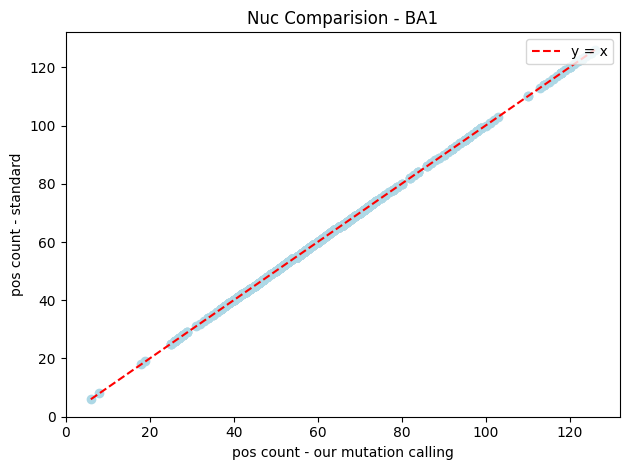

Empty DataFrame
Columns: [sra, pos_count_standard, pos_count_manual, gap]
Index: []


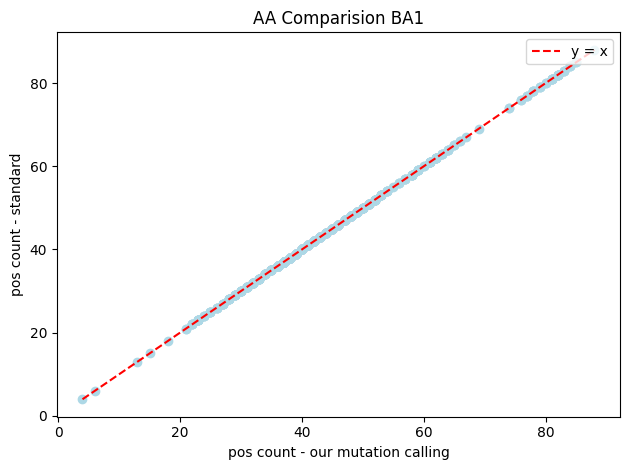

Empty DataFrame
Columns: [sra, pos_count_standard, pos_count_manual, gap]
Index: []
68715
68715


Empty DataFrame
Columns: []
Index: []

In [ ]:
common_set = get_common_seqs(ba275_gf_dir+"alignment.fasta", sc2_escape_dir+"alignment.fasta")

ba275_gf, ba275_gf_filtered = process(ba275_gf_dir+"mutations.tsv", common_set)
ba275_mm, ba275_mm_filtered = process(sc2_escape_dir+"NC_045512.2_escape_BA.2.75_rbd_mutations.tsv", common_set)


print(round(len(ba275_mm_filtered)/len(ba275_mm), 2)*100, "% sequences in the alignment files are identical.")

pos_mismatch = corr_plt_nuc(ba275_gf_filtered, ba275_mm_filtered, "BA.2.75")
print(pos_mismatch)
pos_mismatch = corr_plt_aa(ba275_gf_filtered, ba275_mm_filtered, "BA.2.75")
print(pos_mismatch)

tmp1 = (ba275_gf_filtered[~ba275_gf_filtered["alt"].isin(ambiguous_nuc)]
        .drop(columns=["ref_codon", "alt_codon"])
        .sort_values(by=["sra", "pos", "GFF_FEATURE"])
        .reset_index(drop=True)
)

ba275_mm_filtered.loc[(ba275_mm_filtered["ref_aa"] == "X") | (ba275_mm_filtered["alt_aa"] == "X"), ["GFF_FEATURE", "ref_aa", "alt_aa", "pos_aa"]] = np.nan
tmp2 = (ba275_mm_filtered[~ba275_mm_filtered["alt"].isin(ambiguous_nuc)]
        .drop(columns=["ref_codon", "alt_codon"])
        .sort_values(by=["sra", "pos", "GFF_FEATURE"])
        .drop_duplicates()
        .reset_index(drop=True)
)

print(len(tmp1))
print(len(tmp2))
tmp1.compare(tmp2, keep_equal=True)



100.0 % sequences in the alignment files are identical.


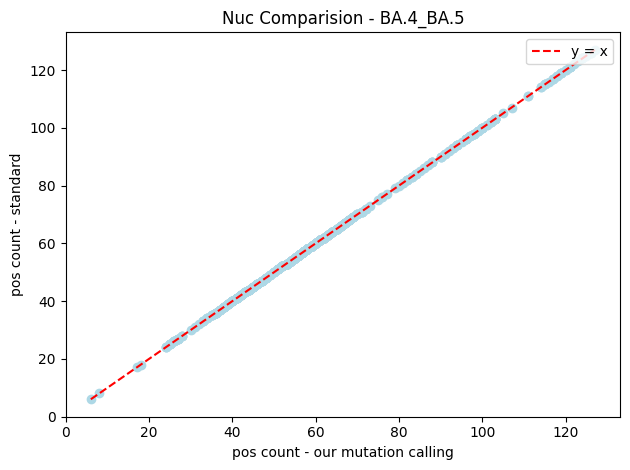

Empty DataFrame
Columns: [sra, pos_count_standard, pos_count_manual, gap]
Index: []


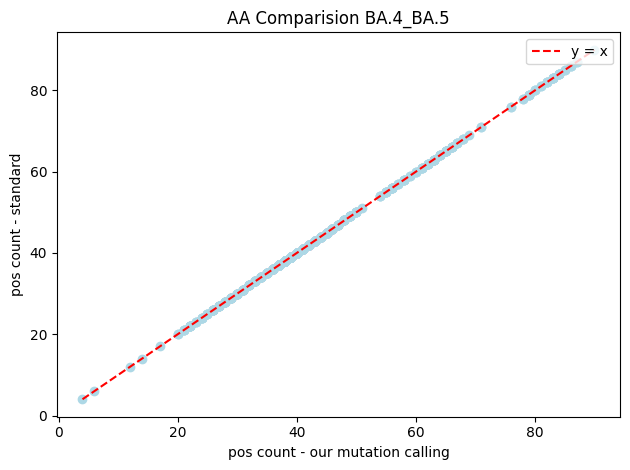

Empty DataFrame
Columns: [sra, pos_count_standard, pos_count_manual, gap]
Index: []
67455
67455


Empty DataFrame
Columns: []
Index: []

In [24]:
common_set = get_common_seqs(ba45_gf_dir+"alignment.fasta", sc2_escape_dir+"alignment.fasta")

ba45_gf, ba45_gf_filtered = process(ba45_gf_dir+"mutations.tsv", common_set)
ba45_mm, ba45_mm_filtered = process(sc2_escape_dir+"NC_045512.2_escape_BA.4-BA.5_rbd_mutations.tsv", common_set)


print(round(len(ba45_mm_filtered)/len(ba45_mm), 2)*100, "% sequences in the alignment files are identical.")

pos_mismatch = corr_plt_nuc(ba45_gf_filtered, ba45_mm_filtered, "BA.4_BA.5")
print(pos_mismatch)
pos_mismatch = corr_plt_aa(ba45_gf_filtered, ba45_mm_filtered, "BA.4_BA.5")
print(pos_mismatch)

tmp1 = (ba45_gf_filtered[~ba45_gf_filtered["alt"].isin(ambiguous_nuc)]
        .drop(columns=["ref_codon", "alt_codon"])
        .sort_values(by=["sra", "pos", "GFF_FEATURE"])
        .reset_index(drop=True)
)

ba45_mm_filtered.loc[(ba45_mm_filtered["ref_aa"] == "X") | (ba45_mm_filtered["alt_aa"] == "X"), ["GFF_FEATURE", "ref_aa", "alt_aa", "pos_aa"]] = np.nan
tmp2 = (ba45_mm_filtered[~ba45_mm_filtered["alt"].isin(ambiguous_nuc)]
        .drop(columns=["ref_codon", "alt_codon"])
        .sort_values(by=["sra", "pos", "GFF_FEATURE"])
        .drop_duplicates()
        .reset_index(drop=True)
)

print(len(tmp1))
print(len(tmp2))
tmp1.compare(tmp2, keep_equal=True)



100.0 % sequences in the alignment files are identical.


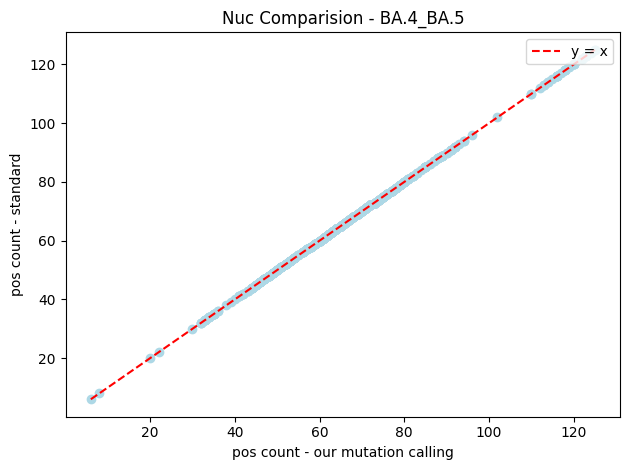

Empty DataFrame
Columns: [sra, pos_count_standard, pos_count_manual, gap]
Index: []


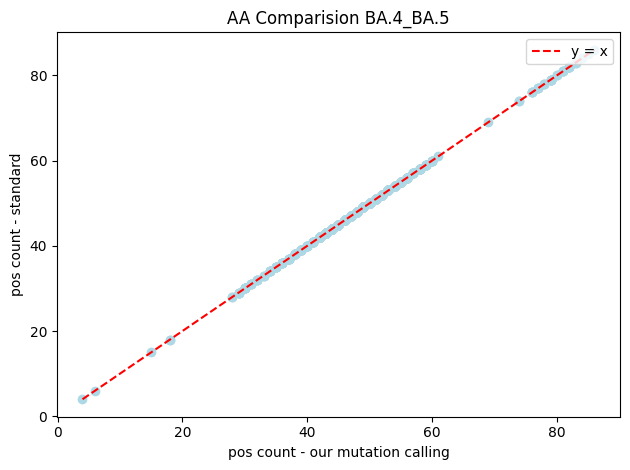

Empty DataFrame
Columns: [sra, pos_count_standard, pos_count_manual, gap]
Index: []
73762
73762


ref         alt      
      self other  self other
9222     t     T  -tta  -TTA
20792    g     G  -tgt  -TGT
20911    g     G  -tgt  -TGT
21247    a     A  -tgg  -TGG
21383    g     G  -tgt  -TGT
21510    g     G  -tgt  -TGT
21642    g     G  -tgt  -TGT
21770    g     G  -tgt  -TGT
21905    g     G  -tgt  -TGT
22035    g     G  -tgt  -TGT
22172    g     G  -tgt  -TGT
22302    g     G  -tgt  -TGT
22433    g     G  -tgt  -TGT
22567    g     G  -tgt  -TGT
22706    g     G  -tgt  -TGT
22842    g     G  -tgt  -TGT
22978    g     G  -tgt  -TGT
23107    g     G  -tgt  -TGT
23233    g     G  -tgt  -TGT
23366    g     G  -tgt  -TGT
23504    g     G  -tgt  -TGT
23641    g     G  -tgt  -TGT
23780    g     G  -tgt  -TGT
23916    g     G  -tgt  -TGT
24051    g     G  -tgt  -TGT
24190    g     G  -tgt  -TGT
24324    g     G  -tgt  -TGT
24465    g     G  -tgt  -TGT
24611    g     G  -tgt  -TGT
24751    g     G  -tgt  -TGT
24885    g     G  -tgt  -TGT
25022    g     G  -tgt  -TGT
25166    g     G  -tgt  -TGT
25307    g     G  -tgt  -TGT
32456    g     G  -tgt  -TGT
32692    g     G  -tgt  -TGT
32826    g     G  -tgt  -TGT
33161    g     G  -tgt  -TGT
33293    g     G  -tgt  -TGT
73718    g     G  -tgt  -TGT

In [26]:
common_set = get_common_seqs(xbb_gf_dir+"alignment.fasta", sc2_escape_dir+"alignment.fasta")

xbb_gf, xbb_gf_filtered = process(xbb_gf_dir+"mutations.tsv", common_set)
xbb_mm, xbb_mm_filtered = process(sc2_escape_dir+"NC_045512.2_escape_XBB.1.5_rbd_mutations.tsv", common_set)


print(round(len(xbb_mm_filtered)/len(xbb_mm), 2)*100, "% sequences in the alignment files are identical.")

pos_mismatch = corr_plt_nuc(xbb_gf_filtered, xbb_mm_filtered, "BA.4_BA.5")
print(pos_mismatch)
pos_mismatch = corr_plt_aa(xbb_gf_filtered, xbb_mm_filtered, "BA.4_BA.5")
print(pos_mismatch)

tmp1 = (xbb_gf_filtered[~xbb_gf_filtered["alt"].isin(ambiguous_nuc)]
        .drop(columns=["ref_codon", "alt_codon"])
        .sort_values(by=["sra", "pos", "GFF_FEATURE"])
        .reset_index(drop=True)
)

xbb_mm_filtered.loc[(xbb_mm_filtered["ref_aa"] == "X") | (xbb_mm_filtered["alt_aa"] == "X"), ["GFF_FEATURE", "ref_aa", "alt_aa", "pos_aa"]] = np.nan
tmp2 = (xbb_mm_filtered[~xbb_mm_filtered["alt"].isin(ambiguous_nuc)]
        .drop(columns=["ref_codon", "alt_codon"])
        .sort_values(by=["sra", "pos", "GFF_FEATURE"])
        .drop_duplicates()
        .reset_index(drop=True)
)

print(len(tmp1))
print(len(tmp2))
tmp1.compare(tmp2, keep_equal=True)



In [ ]:
m = pd.merge(tmp1, tmp2, how="outer",  indicator=True)
m[m["_merge"] != "both"]

,sra,region,pos,ref,alt,GFF_FEATURE,ref_aa,alt_aa,pos_aa,_merge
35,hCoV-19/Iraq/KR-SEARCH-119827/2021,NC_045512.2,22578,A,G,YP_009724390.1,D,G,339.0,left_only
46,hCoV-19/Iraq/KR-SEARCH-119827/2021,NC_045512.2,23018,G,T,YP_009724390.1,V,F,486.0,left_only
100,hCoV-19/Iraq/KR-SEARCH-119946/2021,NC_045512.2,22578,A,G,YP_009724390.1,D,G,339.0,left_only
111,hCoV-19/Iraq/KR-SEARCH-119946/2021,NC_045512.2,23018,G,T,YP_009724390.1,V,F,486.0,left_only
162,hCoV-19/Iraq/KR-SEARCH-119954/2021,NC_045512.2,22578,A,G,YP_009724390.1,D,G,339.0,left_only
...,...,...,...,...,...,...,...,...,...,...
71237,hCoV-19/USA/TX-SEARCH-233270/2023,NC_045512.2,22916,C,T,YP_009724390.1,L,W,452.0,right_only
71238,hCoV-19/USA/TX-SEARCH-233270/2023,NC_045512.2,22917,T,G,YP_009724390.1,L,W,452.0,right_only
71239,hCoV-19/USA/TX-SEARCH-233270/2023,NC_045512.2,22942,G,A,NaN,NaN,NaN,NaN,right_only
71240,hCoV-19/USA/TX-SEARCH-233270/2023,NC_045512.2,23018,T,C,YP_009724390.1,F,P,486.0,right_only


In [ ]:
hCoV-19/Iraq/KR-SEARCH-119827/2021	NC_045512.2	23018	G	T	YP_009724390.1			V	F	486


,sra,region,pos,ref,alt,GFF_FEATURE,ref_aa,alt_aa,pos_aa
0,hCoV-19/Iraq/KR-SEARCH-119827/2021,NC_045512.2,210,G,T,NaN,NaN,NaN,NaN
1,hCoV-19/Iraq/KR-SEARCH-119827/2021,NC_045512.2,241,C,T,NaN,NaN,NaN,NaN
2,hCoV-19/Iraq/KR-SEARCH-119827/2021,NC_045512.2,3037,C,T,NaN,NaN,NaN,NaN
3,hCoV-19/Iraq/KR-SEARCH-119827/2021,NC_045512.2,3099,C,A,YP_009724389.1,T,N,945.0
4,hCoV-19/Iraq/KR-SEARCH-119827/2021,NC_045512.2,3099,C,A,YP_009725295.1,T,N,945.0
...,...,...,...,...,...,...,...,...,...
68710,hCoV-19/USA/TX-SEARCH-233270/2023,NC_045512.2,28882,G,A,YP_009724397.2,R,K,203.0
68711,hCoV-19/USA/TX-SEARCH-233270/2023,NC_045512.2,28883,G,C,YP_009724397.2,G,R,204.0
68712,hCoV-19/USA/TX-SEARCH-233270/2023,NC_045512.2,28958,C,A,YP_009724397.2,Q,K,229.0
68713,hCoV-19/USA/TX-SEARCH-233270/2023,NC_045512.2,29510,A,C,YP_009724397.2,S,R,413.0


In [ ]:
/home/yutianc/bjorn_rep/output/Hu1/escape_all/NC_045512.2_escape_BA.2.75_rbd.fa_mutations.tsv

In [ ]:
f = list(SeqIO.parse("/home/yutianc/bjorn_rep/data/PB2-DMS/PB2_samples/SRR33319052_PB2_cns.fa", "fasta"))
count = f[0].seq.count('-')+f[0].seq.count('N')
print(count/len(f[0].seq)*100)